In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('../..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import spacy

import matplotlib.pyplot as plt
import clean_dataset as clean
import make_dataset as mk
import vectorize_embed as em
import tools as tools
import models as m

import pickle
import numpy as np

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline

'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

import joblib
import seaborn as sns

[nltk_data] Downloading package stopwords to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
'''import data'''

df = pd.read_csv(os.path.abspath(os.path.join('../..', 'data/processed/encoded_labels'))+'/transformed_sectors.csv')  
'''lowercase data and str type data'''
df['all_text_clean_spacy'] = df['all_text_clean_spacy'].astype(str).apply(clean.basic)
df['all_text_clean'] = df['all_text_clean'].astype(str)

In [4]:
print(df.shape)
print(df.columns)

(576, 24)
Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'transformed_sectors', '_asgm', '_coal', '_metals_and_mining',
       '_oil_gas_and_fuels', '_shipping', 'agriculture', 'aquaculture',
       'electronic', 'energy', 'fisheries', 'forestry_and_other_land_use',
       'health_care', 'high_tech', 'livestock', 'materials_and_manufacturing',
       'no tag', 'other_sectors', 'retail', 'tourism', 'transportation'],
      dtype='object')


<AxesSubplot:>

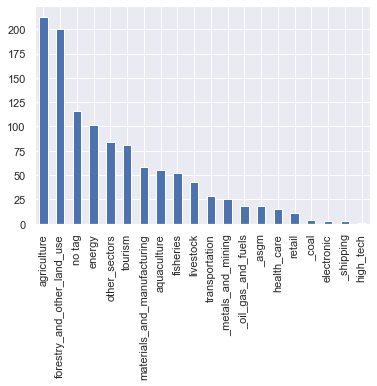

In [5]:
df[['_asgm', '_coal', '_metals_and_mining',
       '_oil_gas_and_fuels', '_shipping', 'agriculture', 'aquaculture',
       'electronic', 'energy', 'fisheries', 'forestry_and_other_land_use',
       'health_care', 'high_tech', 'livestock', 'materials_and_manufacturing',
       'no tag', 'other_sectors', 'retail', 'tourism', 'transportation']].sum(axis=0).sort_values(ascending = False).plot.bar()

In [14]:
for category in categories:
    if category != "no tag":
        if df[category].sum(axis=0) > 17:
            print(category)
    

_asgm
_metals_and_mining
_oil_gas_and_fuels
agriculture
aquaculture
energy
fisheries
forestry_and_other_land_use
livestock
materials_and_manufacturing
other_sectors
tourism
transportation


In [15]:
categories = ['_asgm',  '_metals_and_mining',
       '_oil_gas_and_fuels', '_shipping', 'agriculture', 'aquaculture',
       'energy', 'fisheries', 'forestry_and_other_land_use',
       'health_care',  'livestock', 'materials_and_manufacturing',
     'other_sectors', 'retail', 'tourism', 'transportation', 'no tag', 'high_tech','_shipping', 'electronic', '_coal']

In [16]:
# iterate over categories and save best models:
    #Creating a dict of the models
model_dict = {
              'Logistic Regression balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'Logistic Regression' : LogisticRegression(random_state = 3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Stochastic Gradient Descent balanceed' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}
    
for category in categories: 
    if category != "no tag":
        if df[category].sum(axis=0) > 20:
            
            print('processing:', category)
            print('_____')
            #Creating the features (tf-idf weights) for the processed text
            texts = df['all_text_clean'].astype('str')

            tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                               min_df = 2, 
                                               max_df = .95)
            X = tfidf_vectorizer.fit_transform(texts)     
            y = df[category].values

            if len(category) > 50:
                 shorter = category[0:20]
                 #save vectorizer:
                 filename = '../../models/tf_idf/transformed_sectors/'+shorter+'_'+'vectorizer.sav'
                 joblib.dump(tfidf_vectorizer, filename)    

            else:
                #save vectorizer:
                filename = '../../models/tf_idf/transformed_sectors/'+category+'_'+'vectorizer.sav'
                joblib.dump(tfidf_vectorizer, filename)    

            #Dimenionality reduction. Only using the 100 best features er category
            lsa = TruncatedSVD(n_components=100, 
                               n_iter=10, 
                               random_state=3)
            X = lsa.fit_transform(X)

            if len(category) > 50:
                print('long')
                shorter = category[0:20]
                #save lsa model:
                filename = '../../models/tf_idf/transformed_sectors/'+shorter+'_'+'lsa.sav'
                joblib.dump(lsa, filename)
            else:
                #save vectorizer:
                filename = '../../models/tf_idf/transformed_sectors/'+category+'_'+'lsa.sav'
                joblib.dump(lsa, filename)  

            #Train test split with stratified sampling for evaluation
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, 
                                                                test_size = .3, 
                                                                shuffle = True, 
                                                                stratify = y, 
                                                                random_state = 3)

            m.model_score_df(model_dict, category, 'transformed_sectors', X_train, X_test, y_train, y_test)

processing: _metals_and_mining
_____
processing: agriculture
_____
processing: aquaculture
_____
processing: energy
_____
processing: fisheries
_____
processing: forestry_and_other_land_use
_____
processing: livestock
_____
processing: materials_and_manufacturing
_____
processing: other_sectors
_____
processing: tourism
_____
processing: transportation
_____
